In [1]:
import logging
# set seed
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
import utils as ut
import experiment as exp
from evaluation import *
from sklearn.metrics import mean_squared_error
from torch.utils.tensorboard import SummaryWriter
import torch
import random
#define fixed_hyperparams and create a config gen
from configurations import RandomConfigGen, Configuration
from torch import nn
from deep_net import RandomNet
from experiment import run_experiment
import regex as re
from pathlib import *
from plot import *
from sk_models import setup_pls_models_exh, StandardScaler, PLSRegression, DeepKNN,CustomWrapper
from tqdm.notebook import tqdm, trange

seed = 1
torch.manual_seed(seed)
random.seed(seed + 1)
np.random.seed(seed + 2)
random_state = np.random.RandomState(seed)
import gc
torch.cuda.empty_cache()
gc.collect()

print(f"GPU detected is {torch.cuda.get_device_name(0)}")
plt.style.use('seaborn-darkgrid')

GPU detected is GeForce GTX 970


In [2]:
id_col_db = {'A_C_OF_ALPHA':["sample_id"],
             'A_C_OF_SIWARE':[],
             'A_AL_RT':[],
             'PLN7':["db_id", "sample_id"],
             'mango_684_990': ['Set','Season','Region','Date','Type','Cultivar','Pop','Temp',"FruitID"]
            }

output_col_db= {'A_C_OF_ALPHA':None,
             'A_C_OF_SIWARE':None,
             'A_AL_RT':None,
             'PLN7':None,
             'mango_684_990': ['DM']
            }


In [3]:
#setup input and output formats, load data

file_name = "PLN7.csv"
dataset_name = re.sub(r'\.(?=csv$)[^.]+$', '',file_name)

file_dir= Path("D:/workspace/lazydeep/experiments/2.00")/dataset_name

In [4]:
preds_db = pd.read_csv(file_dir/"_predictions.csv")

In [5]:
def get_x_y(db):
    target = db["y"]
    values = db.drop("y",axis=1).drop('set_id',axis=1)
    return values,target

preds_all,y_all = get_x_y(preds_db)
model_names = preds_all.columns.to_numpy()

preds_0,y_0 = get_x_y(preds_db[preds_db["set_id"]==0])
preds_1,y_1 = get_x_y(preds_db[preds_db["set_id"]==1])
preds_2,y_2 = get_x_y(preds_db[preds_db["set_id"]==2])
preds_3,y_3 = get_x_y(preds_db[preds_db["set_id"]==3])
preds_4,y_4 = get_x_y(preds_db[preds_db["set_id"]==4])


In [6]:
f = r2_score
cv_r2 = pd.DataFrame({
    'all':{k:f(y_all,preds_all[k]) for k in model_names},
    '0':{k:f(y_0,preds_0[k]) for k in model_names},
    '1':{k:f(y_1,preds_1[k]) for k in model_names},
    '2':{k:f(y_2,preds_2[k]) for k in model_names},
    '3':{k:f(y_3,preds_3[k]) for k in model_names},
    '4':{k:f(y_4,preds_4[k]) for k in model_names}
    }).sort_values("all")

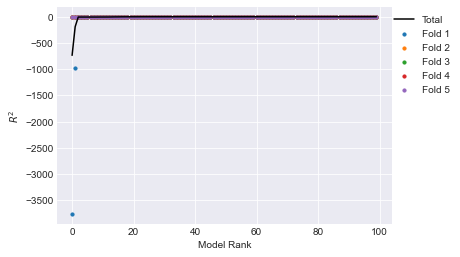

In [7]:
fig, ax = plt.subplots()
ax.plot([i for i in range(0,100)],cv_r2["all"], label='Total',c="black")
ax.scatter(x=[i for i in range(0,100)],y= cv_r2["0"],s=10, label='Fold 1')
ax.scatter(x=[i for i in range(0,100)],y= cv_r2["1"],s=10, label='Fold 2')
ax.scatter(x=[i for i in range(0,100)],y= cv_r2["2"],s=10, label='Fold 3')
ax.scatter(x=[i for i in range(0,100)],y= cv_r2["3"],s=10, label='Fold 4')
ax.scatter(x=[i for i in range(0,100)],y= cv_r2["4"],s=10, label='Fold 5')
#ax.set_ylim(-2,1)
ax.set_xlabel("Model Rank")
ax.set_ylabel(r"$R^2$")
ax.legend(loc='upper right',bbox_to_anchor=(1.2, 1))
plt.savefig(file_dir / f"fold_comparison.png",bbox_inches='tight')

In [8]:
def take_sd(x,y):
    z= np.absolute(np.subtract(x,y))
    return np.std(z)

def take_quantile(x,y,q=0.5):
    z= np.absolute(np.subtract(x,y))
    return np.quantile(z,q)

In [9]:
preds_all,y_all = get_x_y(preds_db)

r2= {k:r2_score(y_all,preds_all[k]) for k in model_names}
rmse= {k:np.sqrt(mean_squared_error(y_all,preds_all[k])) for k in model_names}
mae= {k:mean_absolute_error(y_all,preds_all[k]) for k in model_names}
lq = {k:take_quantile(y_all,preds_all[k],q=0.01) for k in model_names}
med = {k:take_quantile(y_all,preds_all[k],q=0.5) for k in model_names}
uq = {k:take_quantile(y_all,preds_all[k],q=0.99) for k in model_names}

In [10]:
scores_db = pd.DataFrame({
    'r2':r2,
    'rmse':rmse,
    'mae':mae,
    'lq':lq,
    'med':med,
    'uq':uq
}).sort_values("r2")

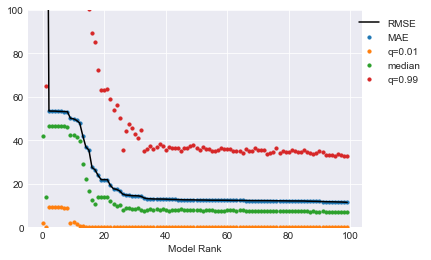

In [11]:
fig, ax = plt.subplots()
ax.plot([i for i in range(0,100)],scores_db["rmse"],c='black', label='RMSE')
ax.scatter(x=[i for i in range(0,100)],y= scores_db["rmse"],s=10, label='MAE')
ax.scatter(x=[i for i in range(0,100)],y= scores_db["lq"],s=10, label='q=0.01')
ax.scatter(x=[i for i in range(0,100)],y= scores_db["med"],s=10, label='median')
ax.scatter(x=[i for i in range(0,100)],y= scores_db["uq"],s=10, label='q=0.99')

ax.set_xlabel("Model Rank")
ax.legend(loc='upper right',bbox_to_anchor=(1.2, 1))
ax.set_ylim(0,100)
plt.savefig(file_dir / f"error_distributions.png",bbox_inches='tight')